In [1]:
import os
import numpy as np

from lib.constants import *
from lib.chicken import *
from lib.controllers import *
from lib.utils import *
from lib.state import *
from lib.user import *
from lib.testers import *
from lib.log import *
from lib.plots import *

In [2]:
# Suppress warnings
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# cadCAD standard dependencies

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

# cadCAD global simulation configuration list
from cadCAD import configs

# Included with cadCAD
import pandas as pd

# Additional dependencies

# For analytics
import numpy as np
# For visualization
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from explain_beta_helper import composer
from scipy.stats import betabinom


# --- AGENT'S PROPENSITIES - keep in mind, these are properties of the agent
age_r, age_v, age_m = np.array([0, 35]), 3, "polynomial"
vol_r, vol_v, vol_m = np.array([1e3, 5e6]), 1, "logarithmic"
ins_r, ins_v, ins_m = np.array([0, 5]), 1, "linear"
car_r, car_v, car_m = np.array([1, 10]), 1, "uniform"

propensities = {
    "bond_age" : {"range" : age_r, "velocity" : age_v, "modifier" : age_m},
    "traded volume" : {"range" : vol_r, "velocity" : vol_v, "modifier" : vol_m},
    "chicken ins" : {"range" : ins_r, "velocity" : ins_v, "modifier" : ins_m},
    "yellow cars" : {"range" : car_r, "velocity" : car_v, "modifier" : car_m}
}


In [5]:
def deploy():
    coll = Token('ETH')
    lqty = Token('LQTY')
    slqty = Token('sLQTY')

    chicken = Chicken(coll, lqty, slqty, "Coop", "POL", "AMM", AMM_FEE, "STOKEN_AMM", AMM_FEE)

    chicks = list(map(lambda chick: User(f"chick_{chick:02}"), range(NUM_CHICKS)))
    # Initial CHICK balance
    for chick in chicks:
        lqty.mint(chick.account, INITIAL_AMOUNT)

    borrower = User("borrower")
    #lqty.mint(borrower.account, INITIAL_AMOUNT)

    # Add funds to sLQTY AMM pool:
    whale = User("whale")
    whale_amount = NUM_CHICKS * INITIAL_AMOUNT * 100000
    lqty.mint(whale.account, whale_amount)
    chicken.stoken_amm.add_liquidity_single_A(whale.account, whale_amount, 1)
    # to be discounted for APR calculation
    chicken.stoken_amm.set_initial_A_liquidity(whale_amount)

    return chicken, chicks, borrower

In [6]:
### TODO - Modify this class to incoporate custom decision-making.
class TesterModifiedAgent(TesterSimpleToll):
    def __init__(self):
        super().__init__()
        
#         self.
        
        return


    def chicken_in(self, chicken, chick, iteration, data, n_ins_prev_day):

        if iteration < BOOTSTRAP_ITERATION:
            return 0, 0, 0

        claimable_amount, bond_cap = self.get_claimable_amount(chicken, chick, iteration)
        if claimable_amount == 0:
            return
        amm_token_amount, amm_coll_amount = self.get_amm_amounts(chicken, bond_cap, claimable_amount)

        # Return if agent decision returns 0
        age_v1 = iteration - chick.bond_time
        vol_v1 = 3.2e2
        ins_v1 = n_ins_prev_day
        car_v1 = 3
        v = {
            "bond_age" : age_v1,
            "traded volume" : vol_v1,
            "chicken ins" : n_ins_prev_day,
            "yellow cars" : car_v1,
        }

        output_params = composer(propensities, v)
        a, b = output_params[1]

        outcome = betabinom.rvs(1, a, b)        
        if not outcome:
            return
        
        # if for some reason bond amount goes below lower limit, it’s better to do a regular chicken in and start over
        if chick.rebonder and chick.bond_amount > BOND_AMOUNT[0]:
            # Rebond
            #print("\n \033[33m--> Rebonding!\033[0m")
            new_chicken_in = self.rebond(chicken, chick, claimable_amount, iteration)
        elif chick.lp:
            #print("\n \033[33m--> LP!\033[0m")
            new_chicken_in = self.lp_chicken_in(chicken, chick, claimable_amount, iteration)
        else:
            #print("\n \033[33m--> regular!\033[0m")
            new_chicken_in = self.regular_chicken_in(chicken, chick, claimable_amount, iteration)

        self.chicken_in_counter += new_chicken_in

        # Redirect part of bond to AMM
        if amm_token_amount > 0 and new_chicken_in > 0:
            #print("\n --> Diverting!")
            self.divert_to_amm(chicken, amm_token_amount, amm_coll_amount)

        return
    
    
    def update_chicken(self, chicken, chicks, data, iteration, n_ins_prev_day):
        """ Update the state of each user. Users may:
            - chicken-out
            - chicken-in
        with predefined probabilities.
        """

        np.random.seed(2023 * iteration)
        np.random.shuffle(chicks)

        # ----------- Chicken-out --------------------
        bonded_chicks = self.get_bonded_chicks(chicks)
        #print(f"Bonded Chicks ini: {len(bonded_chicks)}")

        for chick in bonded_chicks:
            pol_ratio = self.get_pol_ratio_update_chicken(chicken, chick, iteration)

            # Check if chicken-out conditions are met and eventually chicken-out
            self.chicken_out(chicken, chick, iteration, data)
        
        # ----------- Chicken-in --------------------
        # LPs first
        bonded_chicks = self.get_bonded_chicks_lps(chicks)
        #print(f"Bonded Chicks: {len(bonded_chicks)}")

        for chick in bonded_chicks:
            pol_ratio = self.get_pol_ratio_update_chicken(chicken, chick, iteration)

            # Check if chicken-in conditions are met and eventually chicken-in
            self.chicken_in(chicken, chick, iteration, data, n_ins_prev_day)

        # Non LPs afterwards
        bonded_chicks = self.get_bonded_chicks_non_lps(chicks)
        #print(f"Bonded Chicks: {len(bonded_chicks)}")

        for chick in bonded_chicks:
            pol_ratio = self.get_pol_ratio_update_chicken(chicken, chick, iteration)

            # Check if chicken-in conditions are met and eventually chicken-in
            self.chicken_in(chicken, chick, iteration, data, n_ins_prev_day)

        #bonded_chicks = self.get_bonded_chicks(chicks)
        #print(f"Bonded Chicks fin: {len(bonded_chicks)}")

        # print("Out:", self.chicken_out_counter)
        # print("In:", self.chicken_in_counter)
        # print("Locked:", self.chicken_in_locked)

        self.chicken_in_locked = 0

        return

In [7]:
tester = TesterModifiedAgent()

chicken, chicks, borrower = deploy()

controller = AsymmetricController(
    adjustment_rate=ACCRUAL_ADJUSTMENT_RATE,
    init_output=INITIAL_ACCRUAL_PARAM
)

data = init_data()
natural_rate = INITIAL_NATURAL_RATE
accrued_fees_A = 0
accrued_fees_B = 0

print(f"\n  --> Model: {tester.name}")
print('  ------------------------------------------------------\n')
# log_state(chicken, chicks, tester, LOG_LEVEL, 0)

tester.init(chicks)


  --> Model: Simple toll model
  ------------------------------------------------------



In [8]:
initial_state = {
    'chicken': chicken,
    'chicks': chicks,
    'borrower': borrower,
    'tester': tester,
    'controller': controller,
    'data': data,
    
    # Controller States
    'accrual_param': INITIAL_ACCRUAL_PARAM,
    'accrual_adj_rate': ACCRUAL_ADJUSTMENT_RATE,
    'target_average_age': TARGET_AVERAGE_AGE,
    
    'natural_rate': tester.get_natural_rate(natural_rate, 0),
    'accrued_fees_A': 0,
    'accrued_fees_B': 0,   
}

In [9]:
system_params = {
    'chicken_out_probability': [0.01],
}

# Policy Functions

In [10]:
def p_factor_params(params, substep, state_history, previous_state):
    tester = previous_state['tester']
    iteration = previous_state['timestep']
    
    # Make alterations on FIRST timestep
    if iteration == 0:
        tester.chicken_out_probability = params['chicken_out_probability']
    
    return {
        'tester': tester,
    }

In [11]:
def p_amm_yield(params, substep, state_history, previous_state):
    chicken = previous_state['chicken']
    chicks = previous_state['chicks']
    data = previous_state['data']
    iteration = previous_state['timestep']
    
    amm = previous_state['chicken'].stoken_amm
    accrued_fees_A = previous_state['accrued_fees_A']
    accrued_fees_B = previous_state['accrued_fees_B']
    chicken.amm_iteration_apr, accrued_fees_A, accrued_fees_B = get_amm_iteration_apr(amm, accrued_fees_A, accrued_fees_B)
    chicken.amm_average_apr = get_amm_average_apr(data, iteration)
#     print(f"AMM iteration APR: {chicken.amm_iteration_apr:.3%}")
#     print(f"AMM average APR: {chicken.amm_average_apr:.3%}")
    assert chicken.amm_iteration_apr >= 0
    
    return {
        'chicken': chicken,
        'accrued_fees_A': accrued_fees_A,
        'accrued_fees_B': accrued_fees_B
    }


def p_distribute_yield(params, substep, state_history, previous_state):
    chicken = previous_state['chicken']
    chicks = previous_state['chicks']
    iteration = previous_state['timestep']
    tester = previous_state['tester']
    
    tester.distribute_yield(chicken, chicks, iteration)
    return {
        'tester': tester,
        'chicken': chicken
    }


def p_users_bond(params, substep, state_history, previous_state):
    chicken = previous_state['chicken']
    chicks = previous_state['chicks']
    iteration = previous_state['timestep']
    tester = previous_state['tester']
    
    tester.bond(chicken, chicks, iteration)
    return {
        'chicks': chicks,
        'chicken': chicken,
        'tester': tester
    }


def p_users_chicken_in_out(params, substep, state_history, previous_state):
    chicken = previous_state['chicken']
    chicks = previous_state['chicks']
    iteration = previous_state['timestep']
    tester = previous_state['tester']
    data = previous_state['data']
    
    if iteration == 0:
        n_ins_prev_day = 0
    elif iteration == 1:
        n_ins_prev_day = state_history[-1][-1]['tester'].chicken_in_counter
    else:
        n_ins_prev_day = state_history[-1][-1]['tester'].chicken_in_counter - state_history[-2][-1]['tester'].chicken_in_counter
#     print('n_ins_prev_day: {}'.format(n_ins_prev_day))
    tester.update_chicken(chicken, chicks, data, iteration, n_ins_prev_day)
    return {
        'chicks': chicks,
        'chicken': chicken,
        'tester': tester
    }


def p_avg_age(params, substep, state_history, previous_state):
    chicks = previous_state['chicks']
    iteration = previous_state['timestep']
    
    avg_age = tester.get_avg_outstanding_bond_age(chicks, iteration)
    return {'avg_age': avg_age}

# State Update Functions

In [12]:
def s_natural_rate(params, substep, state_history, previous_state, policy_input):
    natural_rate = tester.get_natural_rate(previous_state['natural_rate'], previous_state['timestep']+1)
    return 'natural_rate', natural_rate

def s_store_accrued_fees_A(params, substep, state_history, previous_state, policy_input):
    return 'accrued_fees_A', policy_input['accrued_fees_A']

def s_store_accrued_fees_B(params, substep, state_history, previous_state, policy_input):
    return 'accrued_fees_B', policy_input['accrued_fees_B']

# ==========================================

def s_store_chicken_state(params, substep, state_history, previous_state, policy_input):
    return 'chicken', policy_input['chicken']
    
def s_store_chicks_state(params, substep, state_history, previous_state, policy_input):
    return 'chicks', policy_input['chicks']

def s_store_tester_state(params, substep, state_history, previous_state, policy_input):
    return 'tester', policy_input['tester']

def s_store_data_state(params, substep, state_history, previous_state, policy_input):
    return 'data', policy_input['data']


# ==========================================

def s_update_controller_state(params, substep, state_history, previous_state, policy_input):
    avg_age = policy_input['avg_age']

    controller_output = controller.feed(TARGET_AVERAGE_AGE - avg_age)
    return 'controller', controller
    
    
def s_update_accrual_param(params, substep, state_history, previous_state, policy_input):
    controller = previous_state['controller']
    avg_age = policy_input['avg_age']
    tester = previous_state['tester']
    
    controller_output = controller.feed(TARGET_AVERAGE_AGE - avg_age)
    tester.set_accrual_param(controller_output)
    return 'tester', tester

def s_update_data_state(params, substep, state_history, previous_state, policy_input):
    chicken = previous_state['chicken']
    chicks = previous_state['chicks']
    iteration = previous_state['timestep']
    tester = previous_state['tester']
    data = previous_state['data']
    avg_age = policy_input['avg_age']
    natural_rate = previous_state['natural_rate']
    
    if iteration == 1: iteration = 0
    
    new_row = state_to_row(
        chicken,
        tester,
        natural_rate,
        avg_age,
        data,
        iteration
    )
    data = data.append(new_row, ignore_index=True)
    
    return 'data', data

In [13]:
partial_state_update_blocks = [
    {
        'label': 'Experiment Setup - Modifying init state based on params',
        'policies': {
            'modify_tester': p_factor_params,
        },
        'variables': {
            'tester': s_store_tester_state,
        }
    },
    {
        'label': 'Update Natural Rate',
        'policies': {
            
        },
        'variables': {
            'natural_rate': s_natural_rate,
        }
    },
    {
        'label': 'AMM APR Update',
        'policies': {
            'amm_yield': p_amm_yield,
        },
        'variables': {
            'accrued_fees_A': s_store_accrued_fees_A,
            'accrued_fees_B': s_store_accrued_fees_B,
            'chicken': s_store_chicken_state
        }
    },
    {
        'label': 'APR Update & Yield Distribution',
        'policies': {
            'distribute_yield': p_distribute_yield,
        },
        'variables': {
            'chicken': s_store_chicken_state,
            'tester': s_store_tester_state
        }
    },
    {
        'label': 'Users Bond',
        'policies': {
            'users_bond': p_users_bond,
        },
        'variables': {
            'chicken': s_store_chicken_state,
            'chicks': s_store_chicks_state,
            'tester': s_store_tester_state
        }
    },
    {
        'label': 'Users chicken in and out',
        'policies': {
            'users_chicken_in_out': p_users_chicken_in_out,
        },
        'variables': {
            'chicken': s_store_chicken_state,
            'chicks': s_store_chicks_state,
            'tester': s_store_tester_state
        }
    },
    {
        'label': 'Controller Feedback',
        'policies': {
            'avg_age': p_avg_age,
        },
        'variables': {
            'controller': s_update_controller_state,
            'tester': s_update_accrual_param,
            'data': s_update_data_state
        }
    }
]

# Simulation

In [14]:
from cadCAD.configuration import Experiment

from cadCAD import configs
del configs[:] # Clear any prior configs

experiment = Experiment()

In [15]:
SIMULATION_TIMESTEPS = 300

In [16]:
sim_config = config_sim({
    'N': 1,
    'T': range(-1, SIMULATION_TIMESTEPS+1),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config,
)

In [17]:
del configs[:] # Clear any prior configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=experiment.configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 302, 1, 1, 12)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (302, 1, 1, 12)
Execution Method: local_simulations
Execution Mode: single_threaded


/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

Total execution time: 3.46s


/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(new_row, ignore_index=True)
/var/folders/wh/f0v21p1j24j2bjfpxkgmrvcc0000gn/T/ipykernel_23029/2188824632.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [18]:
result = pd.DataFrame(raw_result)
df = result[result['substep'] == len(partial_state_update_blocks)].set_index('timestep')
df['timestep'] = df.index

# System Analysis

In [19]:
get_amm_token = lambda x: x.amm.token_A_balance()
get_amm_coll = lambda x: x.amm.token_B_balance()
get_coop_token = lambda x: x.coop_token_balance()
get_pol_token = lambda x: x.pol_token_balance()
get_stoken_supply = lambda x: x.stoken.total_supply
get_amm_iteration_apr = lambda x: x.amm_iteration_apr
get_amm_average_apr = lambda x: x.amm_average_apr
get_stoken_apr = lambda row: row.tester.get_stoken_apr_spot(row['chicken'], row['data'], row.name)
get_stoken_apr_twap = lambda row: row.tester.get_stoken_apr_twap(row['chicken'], row['data'], row.name)
get_bonding_apr = lambda x: x.tester.get_bonding_apr_spot(x.chicken)
get_bonding_apr_twap = lambda x: x.tester.get_bonding_apr_twap(x.chicken, x.data, x.name)
get_stoken_price = lambda x: x.tester.get_stoken_spot_price(x.chicken)
get_stoken_twap = lambda x: x.tester.get_stoken_twap(x.data, x.name)
get_pol_ratio_with_amm = lambda x: x.chicken.get_pol_ratio_with_amm()
get_pol_ratio_no_amm = lambda x: x.chicken.get_pol_ratio_no_amm()
get_redemption_price = lambda x: tester.get_pol_ratio(x)
get_fair_price = lambda x: tester.get_fair_price(x)

get_rebond_time_data = lambda x: x.tester.get_rebond_time(x.chicken)
get_chicken_in_time = lambda x: x.tester.get_optimal_apr_chicken_in_time(x.chicken)
get_avg_age = lambda x: x.tester.get_avg_outstanding_bond_age(x.chicks, x.name)
get_coop_token = lambda x: x.coop_token_balance()


df['amm_token'] = df['chicken'].apply(get_amm_token)
df['amm_coll'] = df['chicken'].apply(get_amm_coll)
df['coop_token'] = df['chicken'].apply(get_coop_token)
df['pol_token'] = df['chicken'].apply(get_pol_token)
df['stoken_supply'] = df['chicken'].apply(get_stoken_supply)
df['amm_iteration_apr'] = df['chicken'].apply(get_amm_iteration_apr)
df['amm_average_apr'] = df['chicken'].apply(get_amm_average_apr)
df['stoken_apr'] = df.apply(get_stoken_apr, axis=1)
df['stoken_apr_twap'] = df.apply(get_stoken_apr_twap, axis=1)
df['bonding_apr'] = df.apply(get_bonding_apr, axis=1)
df['bonding_apr_twap'] = df.apply(get_bonding_apr_twap, axis=1)
df['stoken_price'] = df.apply(get_stoken_price, axis=1)
df['stoken_twap'] = df.apply(get_stoken_twap, axis=1)
df['pol_ratio_with_amm'] = df.apply(get_pol_ratio_with_amm, axis=1)
df["pol_ratio_no_amm"] = df.apply(get_pol_ratio_no_amm, axis=1)
df['redemption_price'] = df['chicken'].apply(get_redemption_price)
df['fair_price'] = df['chicken'].apply(get_fair_price)

df['rebond_time'] = df.apply(get_rebond_time_data, axis=1)
df['chicken_in_time'] = df.apply(get_chicken_in_time, axis=1)
df['avg_age'] = df.apply(get_avg_age, axis=1)
df['coop_token'] = df['chicken'].apply(get_coop_token)

## 1. Redemption Price / Fair Price

(0.0, 8.0)

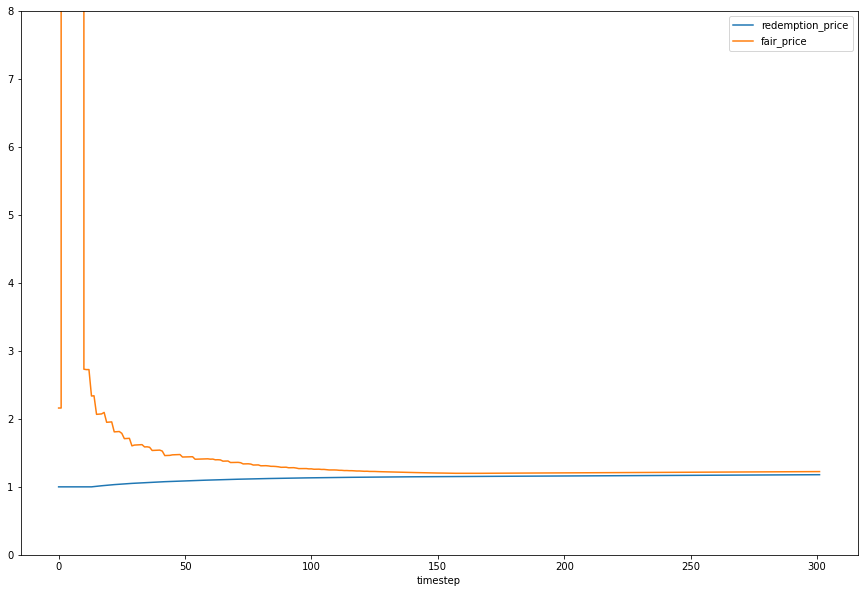

In [20]:
ax1 = df[df['subset'] == 0][['redemption_price', 'fair_price']].plot(figsize=(15,10))
ax1.set_ylim(0,8)

## 2. Chicken-In Time, Re-bond Time, Average Age

(0.0, 160.0)

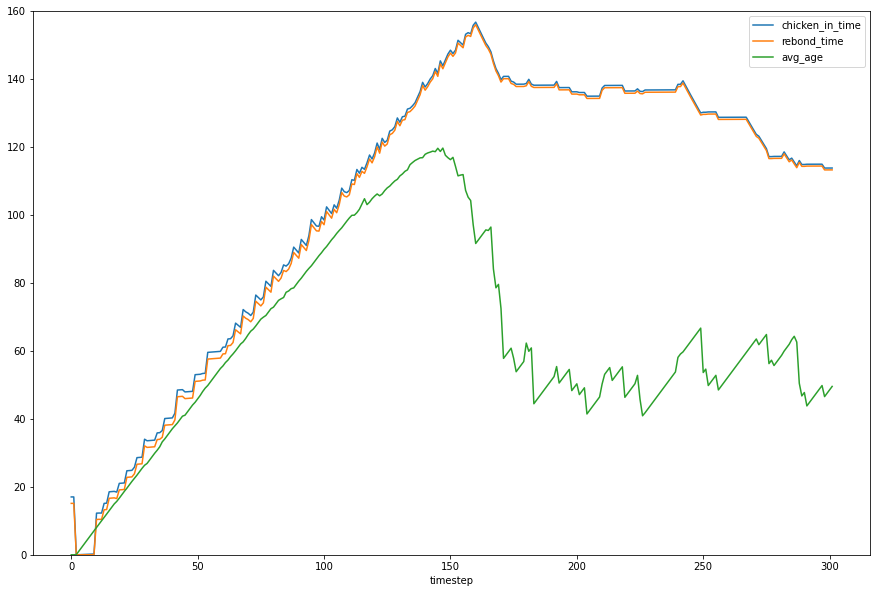

In [21]:
ax1 = df[['chicken_in_time', 'rebond_time', 'avg_age']].plot(figsize=(15,10))
ax1.set_ylim(0,160)

## 3. Temporary Bucket & sTKN Supply over Time

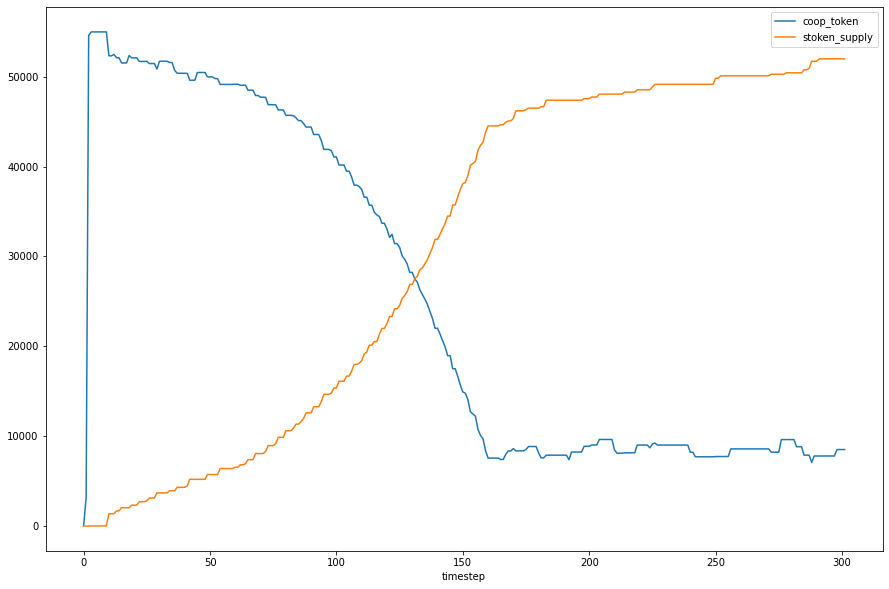

In [22]:
ax1 = df[['coop_token', 'stoken_supply']].plot(figsize=(15,10))

## 4. Accrual Param over Time

<AxesSubplot:xlabel='timestep'>

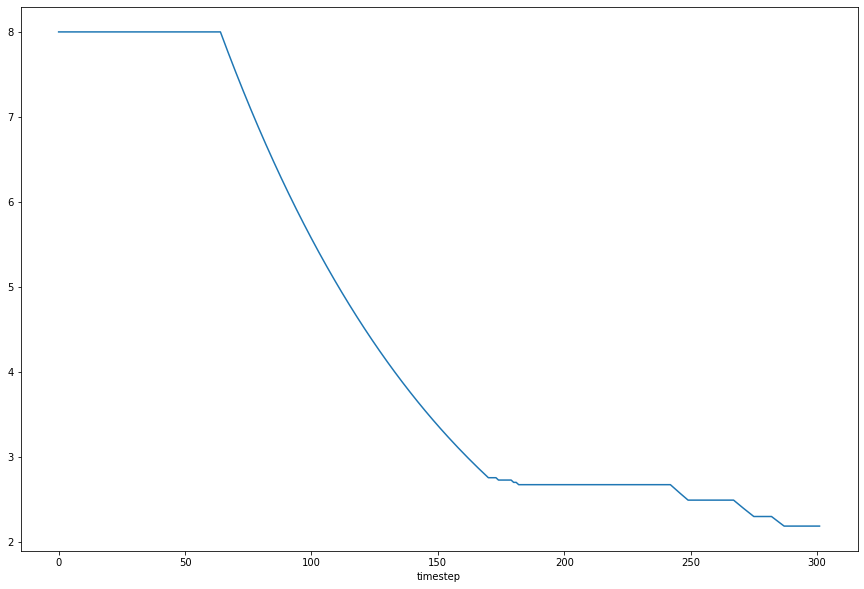

In [23]:
df['accrual_param'] = df['tester'].apply(lambda x: x.accrual_param)

# Equiv.
df['accrual_param'].plot(figsize=(15,10))

## 5. AMM APRs

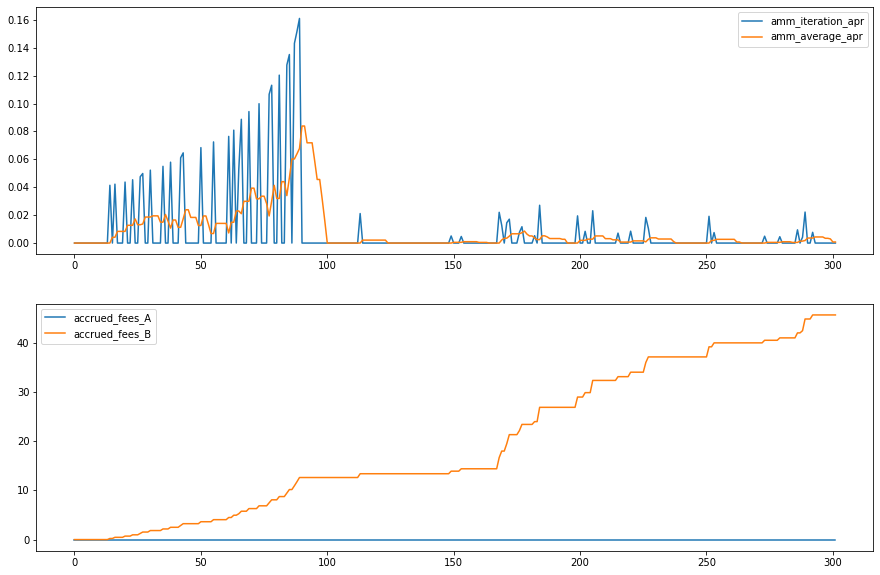

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

plt.subplot(2, 1, 1) # row 1, col 2 index 1
plt.plot(df.index, df[['amm_iteration_apr', 'amm_average_apr']])
plt.legend(['amm_iteration_apr', 'amm_average_apr'])
# ax1 = df[['amm_iteration_apr', 'amm_average_apr']].plot()

plt.subplot(2, 1, 2) # row 1, col 2 index 1
plt.plot(df.index, df[['accrued_fees_A', 'accrued_fees_B']])
plt.legend(['accrued_fees_A', 'accrued_fees_B'])
# ax2 = df[['accrued_fees_A', 'accrued_fees_B']].plot()

## 6. sTKN and Bonding APR

(0.0, 0.1)

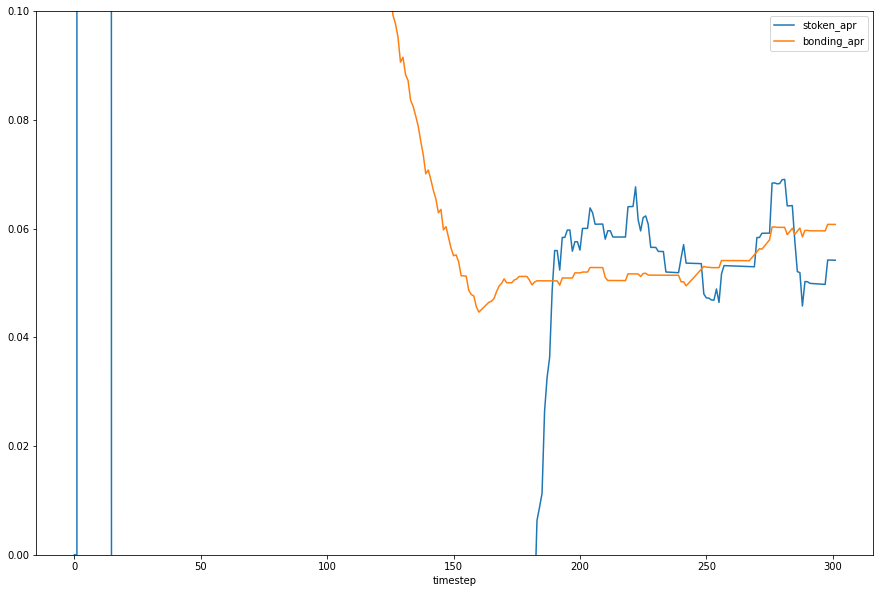

In [25]:
ax1 = df[['stoken_apr', 'bonding_apr']].plot(figsize=(15,10))
ax1.set_ylim(0,0.1)


In [26]:
df.iloc[-1]['tester'].chicken_in_counter

129